In [61]:
import os
import sys
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm
# import xscale as xsc
import xroms
import gc
from netCDF4 import Dataset

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# %matplotlib inline
import seawater as sw
# from pyspec import spectrum as spec

import time
from tqdm import tqdm

# you should need this 
os.chdir('/meddy/simingzhang/Analysis/python/python3/SF3_RLS')
from strucFunct import *
from spectralanalysis import *
from structfunc2KEflux import *

In [2]:
def u2rho_2d_xrray(var_u):
    [Mp, L] = var_u.shape
    Lp = L + 1
    Lm = L - 1
    
    # 使用 xarray 创建新变量
    var_rho = xr.DataArray(np.zeros((Mp, Lp)), coords=var_u.coords, dims=var_u.dims)
    
    # 计算 var_rho
    var_rho[:, 1:L-1] = 0.5 * (var_u[:, 0:Lm-1] + var_u[:, 1:L-1])
    
    # 边界条件
    var_rho[:, 0] = var_rho[:, 1]  # 左边界
    var_rho[:, Lp-1] = var_rho[:, -2]  # 右边界
    
    return var_rho

def u2rho_3d_xrray(var_u):
    [N, Mp, L] = var_u.shape
    Lp = L + 1
    Lm = L - 1
    
    # 使用 xarray 创建新变量
    var_rho = xr.DataArray(np.zeros((N, Mp, Lp)), coords=var_u.coords, dims=var_u.dims)
    
    # 计算 var_rho
    var_rho[:, :, 1:L-1] = 0.5 * (var_u[:, :, 0:Lm-1] + var_u[:, :, 1:L-1])
    
    # 边界条件
    var_rho[:, :, 0] = var_rho[:, :, 1]  # 左边界
    var_rho[:, :, Lp-1] = var_rho[:, :, -2]  # 右边界
    
    return var_rho

def v2rho_2d_xrray(var_v):
    [M, Lp] = var_v.shape
    Mp = M + 1
    Mm = M - 1
    
    # 使用 xarray 创建新变量
    var_rho = xr.DataArray(np.zeros((Mp, Lp)), coords=var_v.coords, dims=var_v.dims)
    
    # 计算 var_rho
    var_rho[1:M-1, :] = 0.5 * (var_v[0:Mm-1, :] + var_v[1:M-1, :])
    
    # 边界条件
    var_rho[0, :] = var_rho[1, :]  # 上边界
    var_rho[Mp-1, :] = var_rho[-2, :]  # 下边界
    
    return var_rho

def v2rho_3d_xrray(var_v):
    [N, M, Lp] = var_v.shape
    Mp = M + 1
    Mm = M - 1
    
    # 使用 xarray 创建新变量
    var_rho = xr.DataArray(np.zeros((N, Mp, Lp)), coords=var_v.coords, dims=var_v.dims)
    
    # 计算 var_rho
    var_rho[:, 1:M-1, :] = 0.5 * (var_v[:, 0:Mm-1, :] + var_v[:, 1:M-1, :])
    
    # 边界条件
    var_rho[:, 0, :] = var_rho[:, 1, :]  # 上边界
    var_rho[:, Mp-1, :] = var_rho[:, -2, :]  # 下边界
    
    return var_rho

def u2rho_2d (var_u):
    [Mp,L]=var_u.shape
    Lp=L+1
    Lm=L-1
    var_rho=np.zeros((Mp,Lp))
    var_rho[:,1:L-1]=0.5*(var_u[:,0:Lm-1]+var_u[:,1:L-1])
    var_rho[:,0]=var_rho[:,1]
    var_rho[:,Lp-1]=var_rho[:,-2]
    return var_rho
    
def v2rho_2d (var_v):
    [M,Lp]=var_v.shape
    Mp=M+1
    Mm=M-1
    var_rho=np.zeros((Mp,Lp))
    var_rho[1:M-1,:]=0.5*(var_v[0:Mm-1,:]+var_v[1:M-1,:])
    var_rho[0,:]=var_rho[1,:]
    var_rho[Mp-1,:]=var_rho[-2,:]
    return var_rho

def u2rho_3d (var_u):
    [N,Mp,L]=var_u.shape
    Lp=L+1
    Lm=L-1
    var_rho=np.zeros((N,Mp,Lp))
    var_rho[:,:,1:L-1]=0.5*(var_u[:,:,0:Lm-1]+var_u[:,:,1:L-1])
    var_rho[:,:,0]=var_rho[:,:,1]
    var_rho[:,:,Lp-1]=var_rho[:,:,-2]
    return var_rho
    
def v2rho_3d (var_v):
    [N,M,Lp]=var_v.shape
    Mp=M+1
    Mm=M-1
    var_rho=np.zeros((N,Mp,Lp))
    var_rho[:,1:M-1,:]=0.5*(var_v[:,0:Mm-1,:]+var_v[:,1:M-1,:])
    var_rho[:,0,:]=var_rho[:,1,:]
    var_rho[:,Mp-1,:]=var_rho[:,-2,:]
    return var_rho

def add_new_var_to_dataset_2d(ds, var_name, var_values):
    """
    将一个新的变量添加到现有的 xarray Dataset 中。

    参数:
    ds: xarray.Dataset
        要添加变量的原始 Dataset。
    var_name: str
        新变量的名称。
    var_values: array-like
        用于填充新变量的值。可以是一个二维数组，形状应与 eta_rho 和 xi_rho 坐标匹配。

    返回:
    ds: xarray.Dataset
        更新后的 Dataset，包含新的 DataArray。
    """
    # 获取 eta_rho 和 xi_rho 坐标
    eta_rho = ds.coords['eta_rho']
    xi_rho = ds.coords['xi_rho']

    # 创建新的 DataArray
    new_var = xr.DataArray(var_values, 
                           coords={'eta_rho': eta_rho, 'xi_rho': xi_rho},
                           dims=['eta_rho', 'xi_rho'], 
                           name=var_name)

    # 将新的 DataArray 加入到 Dataset
    ds[var_name] = new_var

    return ds

def add_new_var_to_dataset_3d(ds, var_name, var_values):
    """
    将一个新的变量添加到现有的 xarray Dataset 中。

    参数:
    ds: xarray.Dataset
        要添加变量的原始 Dataset。
    var_name: str
        新变量的名称。
    var_values: array-like
        用于填充新变量的值。可以是一个二维数组，形状应与 eta_rho 和 xi_rho 坐标匹配。

    返回:
    ds: xarray.Dataset
        更新后的 Dataset，包含新的 DataArray。
    """
    # 获取 eta_rho 和 xi_rho 坐标
    eta_rho = ds.coords['eta_rho']
    xi_rho = ds.coords['xi_rho']
    time = ds.coords['time']
    # 创建新的 DataArray
    new_var = xr.DataArray(var_values, 
                           coords={'time':time,'eta_rho': eta_rho, 'xi_rho': xi_rho},
                           dims=['time','eta_rho', 'xi_rho'], 
                           name=var_name)

    # 将新的 DataArray 加入到 Dataset
    ds[var_name] = new_var

    return ds

def tridim(var2d, N):
    """
    Put a 2D matrix in 3D (reproduce it N times).
    
    Parameters:
    - var2d: 2D numpy array
    - N: integer, the number of times to replicate the 2D array in the 3rd dimension
    
    Returns:
    - var3d: 3D numpy array where var2d is replicated N times along the 3rd axis
    """
    M, L = var2d.shape
    var3d = np.reshape(var2d, (1, M, L))  # Reshape the 2D array to 3D
    var3d = np.tile(var3d, (N, 1, 1))  # Replicate the array N times along the first axis
    return var3d




def calc_ispec(k, l, E, ndim=2):
    """
    Calculates the azimuthally-averaged spectrum.

    Parameters
    ----------
    E : ndarray
        The two-dimensional or three-dimensional spectrum.
    k : ndarray
        The wavenumber in the x-direction.
    l : ndarray
        The wavenumber in the y-direction.
    ndim : int, optional
        The dimension of the input data (default is 2).

    Returns
    -------
    kr : ndarray
        The radial wavenumber.
    Er : ndarray
        The azimuthally-averaged spectrum.
    """
    
    # Compute the wavenumber step sizes
    dk = np.abs(k[1] - k[0])
    dl = np.abs(l[1] - l[0])
    
    # Create a meshgrid for k and l
    K, L = np.meshgrid(k, l)
    
    # Compute the wavenumber magnitude
    wv = np.sqrt(K**2 + L**2)
    
    # Find the maximum wavenumber
    kmax = max(np.max(k), np.max(l))
    
    # Get the size of E depending on ndim
    if ndim == 3:
        nl, nk, nomg = E.shape
    elif ndim == 2:
        nomg = 1
    else:
        raise ValueError("ndim should be 2 or 3")
    
    # Compute the radial bin width
    dkr = np.sqrt(dk**2 + dl**2)
    
    # Create the radial wavenumber range
    kr = np.arange(dkr / 2, kmax + dkr / 2, dkr)
    
    # Initialize the output
    Er = np.zeros((len(kr), nomg))
    
    # Loop through each radial bin
    for i in range(len(kr)):
        # Find the wavenumbers within the current radial bin
        fkr = (wv >= kr[i] - dkr / 2) & (wv <= kr[i] + dkr / 2)
        
        # Compute the angular bin width
        dth = np.pi / (np.sum(fkr) - 1)
        
        # Perform the azimuthal averaging
        if ndim == 2:
            Er[i] = np.sum(E[fkr] * (wv[fkr] * dth))
        elif ndim == 3:
            Er[i] = np.sum(np.sum(E[fkr] * (wv[fkr] * dth), axis=0), axis=0)
    
    # Squeeze Er to remove singleton dimensions
    Er = np.squeeze(Er)
    
    return kr, Er




def detrend_demean(un,vn):
     # Removes trends and mean
    un = un - np.mean(un)
    vn = vn - np.mean(vn)
    un = sig.detrend(un, axis=0, type='linear')
    un = sig.detrend(un, axis=1, type='linear')
    vn = sig.detrend(vn, axis=0, type='linear')
    vn = sig.detrend(vn, axis=1, type='linear')
    return un,vn
    
#### new test

def test2_calc_SF2(u, v, N):
    # Create a meshgrid
    X, Y = np.meshgrid(np.arange(-N/2, N/2), np.arange(-N/2, N/2))
    R = np.sqrt(X**2 + Y**2)
    cost = X / R
    sint = Y / R

    # Handle division by zero (where R == 0)
    cost[R == 0] = 0
    sint[R == 0] = 0

    # Compute 2D Fourier transforms
    uh = np.fft.fft2(u)
    vh = np.fft.fft2(v)

    # Compute autocorrelations and cross-correlations
    Cuu = np.fft.fftshift(np.fft.ifft2(uh * np.conj(uh) / (N**2)))
    Cvv = np.fft.fftshift(np.fft.ifft2(vh * np.conj(vh) / (N**2)))
    Cuv = np.fft.fftshift(np.fft.ifft2(uh * np.conj(vh) / (N**2)))
    Cvu = np.fft.fftshift(np.fft.ifft2(vh * np.conj(uh) / (N**2)))

    # # Compute Ruu, Rvv, Ruv, Rvu
    # Ruu = Cuu * cost**2 + Cvv * sint**2 + sint * cost * (Cuv + Cvu)
    # Rvv = Cvv * sint**2 + Cvv * cost**2 + sint * cost * (Cuv + Cvu)
    # Ruv = (Cuu - Cvv) * cost * sint + Cvu * sint**2 - Cuv * cost**2
    # Rvu = (Cuu - Cvv) * cost * sint - Cvu * cost**2 + Cuv * sint**2

    # Compute mean values
    u2 = np.mean(u**2)
    v2 = np.mean(v**2)
    uv = np.mean(u) * np.mean(v)

    # Compute S_transverse and S_longitudinal
    S_transverse = 2 * (u2 * sint**2 + v2 * cost**2 - 2 * uv * sint * cost) - \
                   2 * (Cuu * sint**2 - (Cuv + Cvu) * sint * cost + Cvv * cost**2)

    S_longitudinal = 2 * (u2 * cost**2 + v2 * sint**2 + 2 * uv * sint * cost) - \
                     2 * (Cuu * cost**2 + (Cuv + Cvu) * sint * cost + Cvv * sint**2)

    # Compute radial distances
    rx = np.arange(-N/2, N/2)
    ry = np.arange(-N/2, N/2)
    rr = np.unique(np.sqrt(rx**2 + ry**2))
    dr = np.sqrt(abs(rx[1] - rx[0])**2 + abs(ry[1] - ry[0])**2)

    # Initialize arrays for St_azimuth and Sl_azimuth
    St_azimuth = np.zeros_like(rr)
    Sl_azimuth = np.zeros_like(rr)

    # Compute St_azimuth and Sl_azimuth
    for ii in range(len(rr)):
        pos = (R >= rr[ii] - dr/2) & (R < rr[ii] + dr/2)
        St_azimuth[ii] = np.mean(S_transverse[pos])
        Sl_azimuth[ii] = np.mean(S_longitudinal[pos])

    # Compute S2
    S2 = 0.5 * (St_azimuth + Sl_azimuth)

    return rr, St_azimuth, Sl_azimuth, S2

def test3_calc_SF2(u, v, N):
    # Create a meshgrid
    X, Y = np.meshgrid(np.arange(-N, N), np.arange(-N, N),indexing='ij')
    R = np.sqrt(X**2 + Y**2)
    cost = X / R
    sint = Y / R

    # Handle division by zero (where R == 0)
    cost[R == 0] = 0
    sint[R == 0] = 0

    # Compute 2D Fourier transforms
    uh = np.fft.fft2(u,s=(2*N-1, 2*N-1))
    vh = np.fft.fft2(v,s=(2*N-1, 2*N-1))

    # Compute autocorrelations and cross-correlations
    Cuu = -np.fft.fftshift(np.fft.ifft2(uh * np.conj(uh) / (N**2)))
    Cvv = -np.fft.fftshift(np.fft.ifft2(vh * np.conj(vh) / (N**2)))
    Cuv = -np.fft.fftshift(np.fft.ifft2(uh * np.conj(vh) / (N**2)))
    Cvu = -np.fft.fftshift(np.fft.ifft2(vh * np.conj(uh) / (N**2)))

    # # Compute Ruu, Rvv, Ruv, Rvu
    # Ruu = Cuu * cost**2 + Cvv * sint**2 + sint * cost * (Cuv + Cvu)
    # Rvv = Cvv * sint**2 + Cvv * cost**2 + sint * cost * (Cuv + Cvu)
    # Ruv = (Cuu - Cvv) * cost * sint + Cvu * sint**2 - Cuv * cost**2
    # Rvu = (Cuu - Cvv) * cost * sint - Cvu * cost**2 + Cuv * sint**2

    # Compute mean values
    u2 = np.mean(u**2)
    v2 = np.mean(v**2)
    uv = np.mean(u) * np.mean(v)

    # Compute S_transverse and S_longitudinal
    S_transverse = 2 * (u2 * sint**2 + v2 * cost**2 - 2 * uv * sint * cost) - \
                   2 * (Cuu * sint**2 - (Cuv + Cvu) * sint * cost + Cvv * cost**2)

    S_longitudinal = 2 * (u2 * cost**2 + v2 * sint**2 + 2 * uv * sint * cost) - \
                     2 * (Cuu * cost**2 + (Cuv + Cvu) * sint * cost + Cvv * sint**2)

    # Compute radial distances
    xx = X[N-1:, N-1:]
    yy = Y[N-1:, N-1:]

    # 处理NaN值
    S_transverse = np.nan_to_num(S_transverse)
    S_longitudinal = np.nan_to_num(S_longitudinal)
    
    # 计算各向同性谱
    r, S2L = calc_ispec(xx[0,:], yy[:,0], S_longitudinal[N-1:, N-1:])
    _, S2T = calc_ispec(xx[0,:], yy[:,0], S_transverse[N-1:, N-1:])
    S2=S2L+S2T
    return r, S2L, S2T, S2

def calc_SF3_iso(u, v, N):
    # 生成坐标网格
    x = np.arange(-N+1, N)
    y = np.arange(-N+1, N)
    X, Y = np.meshgrid(x, y, indexing='xy')
    
    R = np.sqrt(X**2 + Y**2)
    # 避免除以零
    R[R == 0] = np.finfo(float).eps
    cost = X / R
    sint = Y / R
    
    # 计算二次项
    u2 = u**2
    v2 = v**2
    uv = u * v
    
    # 二维FFT（自动补零到2N-1）
    uh = np.fft.fft2(u, s=(2*N-1, 2*N-1))
    vh = np.fft.fft2(v, s=(2*N-1, 2*N-1))
    uuh = np.fft.fft2(u2, s=(2*N-1, 2*N-1))
    vvh = np.fft.fft2(v2, s=(2*N-1, 2*N-1))
    uvh = np.fft.fft2(uv, s=(2*N-1, 2*N-1))
    
    # 计算相关函数（注意FFT归一化）
    scale = (2*N-1)**2  # FFT补零后的尺寸
    Cu_uu = np.fft.fftshift(np.fft.ifft2(uh * np.conj(uuh) / scale))
    Cuu_u = np.fft.fftshift(np.fft.ifft2(uuh * np.conj(uh) / scale))
    Cv_vv = np.fft.fftshift(np.fft.ifft2(vh * np.conj(vvh) / scale))
    Cvv_v = np.fft.fftshift(np.fft.ifft2(vvh * np.conj(vh) / scale))
    
    Cuv_u = np.fft.fftshift(np.fft.ifft2(uvh * np.conj(uh) / scale))
    Cuv_v = np.fft.fftshift(np.fft.ifft2(uvh * np.conj(vh) / scale))
    Cu_uv = np.fft.fftshift(np.fft.ifft2(uh * np.conj(uvh) / scale))
    Cv_uv = np.fft.fftshift(np.fft.ifft2(vh * np.conj(uvh) / scale))
    
    Cuu_v = np.fft.fftshift(np.fft.ifft2(uuh * np.conj(vh) / scale))
    Cvv_u = np.fft.fftshift(np.fft.ifft2(vvh * np.conj(uh) / scale))
    Cv_uu = np.fft.fftshift(np.fft.ifft2(vh * np.conj(uuh) / scale))
    Cu_vv = np.fft.fftshift(np.fft.ifft2(uh * np.conj(vvh) / scale))
    
    # 计算S3分量
    S3L_Roy = (cost**3 * (-3*Cu_uu + 3*Cuu_u) +
               cost**2 * sint * (-6*Cu_uv + 3*Cuu_v + 6*Cuv_u - 3*Cv_uu) +
               cost * sint**2 * (-3*Cu_vv + 6*Cuv_v - 6*Cv_uv + 3*Cvv_u) +
               sint**3 * (-3*Cv_vv + 3*Cvv_v))
    
    S3T_Roy = (cost**3 * (-Cu_vv + 2*Cuv_v - 2*Cv_uv + Cvv_u) +
               cost**2 * sint * (4*Cu_uv - 2*Cuu_v - 4*Cuv_u + 2*Cv_uu - 3*Cv_vv + 3*Cvv_v) +
               cost * sint**2 * (-3*Cu_uu + 2*Cu_vv + 3*Cuu_u - 4*Cuv_v + 4*Cv_uv - 2*Cvv_u) +
               sint**3 * (-2*Cu_uv + Cuu_v + 2*Cuv_u - Cv_uu))
    
    # 提取右上半平面
    S3L_Roy1 = -S3L_Roy[N-1:, N-1:] # cause corelation?
    S3T_Roy1 = -S3T_Roy[N-1:, N-1:]
    
    # 生成对应的坐标
    xx = X[N-1:, N-1:]
    yy = Y[N-1:, N-1:]
    
    # 处理NaN值
    S3L_Roy1 = np.nan_to_num(S3L_Roy1)
    S3T_Roy1 = np.nan_to_num(S3T_Roy1)
    
    # 计算各向同性谱
    r, S3L = calc_ispec(xx[0,:], yy[:,0], S3L_Roy1)
    _, S3T = calc_ispec(xx[0,:], yy[:,0], S3T_Roy1)
    
    return r, S3L, S3T  #

def calc_SF3_iso2(u, v, N):
    # 生成坐标网格
    x = np.arange(-N/2, N/2)
    y = np.arange(-N/2, N/2)
    X, Y = np.meshgrid(x, y, indexing='xy')
    
    R = np.sqrt(X**2 + Y**2)
    # 避免除以零
    R[R == 0] = np.finfo(float).eps
    cost = X / R
    sint = Y / R
    
    # 计算二次项
    u2 = u**2
    v2 = v**2
    uv = u * v
    
    # 二
    uh = np.fft.fft2(u)
    vh = np.fft.fft2(v)
    uuh = np.fft.fft2(u2)
    vvh = np.fft.fft2(v2)
    uvh = np.fft.fft2(uv)
    
    # 计算相关函数（注意FFT归一化）
    scale = (N)**2  # FFT补零后的尺寸
    Cu_uu = -np.fft.fftshift(np.fft.ifft2(uh * np.conj(uuh) / scale))
    Cuu_u = -np.fft.fftshift(np.fft.ifft2(uuh * np.conj(uh) / scale))
    Cv_vv = -np.fft.fftshift(np.fft.ifft2(vh * np.conj(vvh) / scale))
    Cvv_v = -np.fft.fftshift(np.fft.ifft2(vvh * np.conj(vh) / scale))
    
    Cuv_u = -np.fft.fftshift(np.fft.ifft2(uvh * np.conj(uh) / scale))
    Cuv_v = -np.fft.fftshift(np.fft.ifft2(uvh * np.conj(vh) / scale))
    Cu_uv = -np.fft.fftshift(np.fft.ifft2(uh * np.conj(uvh) / scale))
    Cv_uv = -np.fft.fftshift(np.fft.ifft2(vh * np.conj(uvh) / scale))
    
    Cuu_v = -np.fft.fftshift(np.fft.ifft2(uuh * np.conj(vh) / scale))
    Cvv_u = -np.fft.fftshift(np.fft.ifft2(vvh * np.conj(uh) / scale))
    Cv_uu = -np.fft.fftshift(np.fft.ifft2(vh * np.conj(uuh) / scale))
    Cu_vv = -np.fft.fftshift(np.fft.ifft2(uh * np.conj(vvh) / scale))
    
    # 计算S3分量
    S3L_2d = (cost**3 * (-3*Cu_uu + 3*Cuu_u) +
               cost**2 * sint * (-6*Cu_uv + 3*Cuu_v + 6*Cuv_u - 3*Cv_uu) +
               cost * sint**2 * (-3*Cu_vv + 6*Cuv_v - 6*Cv_uv + 3*Cvv_u) +
               sint**3 * (-3*Cv_vv + 3*Cvv_v))
    
    S3T_2d = (cost**3 * (-Cu_vv + 2*Cuv_v - 2*Cv_uv + Cvv_u) +
               cost**2 * sint * (4*Cu_uv - 2*Cuu_v - 4*Cuv_u + 2*Cv_uu - 3*Cv_vv + 3*Cvv_v) +
               cost * sint**2 * (-3*Cu_uu + 2*Cu_vv + 3*Cuu_u - 4*Cuv_v + 4*Cv_uv - 2*Cvv_u) +
               sint**3 * (-2*Cu_uv + Cuu_v + 2*Cuv_u - Cv_uu))
    
    # 提取正频
    # print(S3L_2d.shape)
    S3L_2d1 = S3L_2d[int(N/2):, int(N/2):] # 
    S3T_2d1 = S3T_2d[int(N/2):, int(N/2):]
    
    # 生成对应的坐标
    xx = X[int(N/2):, int(N/2):]
    yy = Y[int(N/2):, int(N/2):]
    
    # 处理NaN值
    S3L_2d1 = np.nan_to_num(S3L_2d1)
    S3T_2d1 = np.nan_to_num(S3T_2d1)
    
    # 计算各向同性谱
    r, S3L = calc_ispec2(xx[0,:], yy[:,0], S3L_2d1)
    _, S3T = calc_ispec2(xx[0,:], yy[:,0], S3T_2d1)
    
    return r, S3L, S3T  #

def calc_ispec(k, l, E, ndim=2):
    """计算方位平均谱"""
    dk = abs(k[1] - k[0])
    dl = abs(l[1] - l[0])
    
    # 生成波数网格
    K, L = np.meshgrid(k, l, indexing='xy')
    wv = np.sqrt(K**2 + L**2)
    
    # 确定最大波数
    kmax = np.max([np.max(k), np.max(l)])
    
    # 分箱设置
    dkr = np.sqrt(dk**2 + dl**2)
    kr = np.arange(dkr/2, kmax + dkr/2, dkr)
    
    # 初始化输出
    if ndim == 3:
        nomg = E.shape[2]
    else:
        nomg = 1
    Er = np.zeros((len(kr), nomg), dtype=np.complex128)
    
    for i in range(len(kr)):
        # 选择当前波数区间
        mask = (wv >= kr[i] - dkr/2) & (wv <= kr[i] + dkr/2)
        # 计算角度积分
        if np.sum(mask) > 0:
            dtheta = np.pi / (np.sum(mask) - 1)
            if ndim == 2:
                Er[i] = np.sum(E[mask] * wv[mask] * dtheta)
            else:
                Er[i] = np.sum(E[mask, :] * wv[mask, None] * dtheta, axis=0)
    
    return kr, np.squeeze(Er)  # 取实数部分

def test4_calc_SF2(u, v, N, dx):
    """
    Calculate azimuthally averaged structure functions from velocity fields
    
    Parameters:
    u, v : 2D numpy arrays
        Velocity fields (N x N)
    N : int
        Grid size
    dx : float
        Grid spacing (physical units, e.g., meters)
        
    Returns:
    R_bins : 1D array
        Distance axis (physical units)
    St_azimuth : 1D array  
        Azimuthally averaged transverse structure function
    Sl_azimuth : 1D array
        Azimuthally averaged longitudinal structure function 
    S2 : 1D array
        Combined structure function
    """
    import numpy as np
    from scipy.fft import fft2, ifft2, fftshift
    
    # Create grid
    x = np.arange(-N//2, N//2)
    y = np.arange(-N//2, N//2)
    X, Y = np.meshgrid(x, y, indexing='ij')
    R = np.sqrt(X**2 + Y**2) * dx  # Physical distance matrix
    
    # Handle division by zero for cost/sint
    with np.errstate(divide='ignore', invalid='ignore'):
        cost = X / (R/dx)
        sint = Y / (R/dx)
        cost[np.isnan(cost)] = 0
        sint[np.isnan(sint)] = 0
    
    # Compute velocity correlations
    uh = fft2(u)
    vh = fft2(v)
    Cuu = fftshift(ifft2(uh * np.conj(uh))) / N**2
    Cvv = fftshift(ifft2(vh * np.conj(vh))) / N**2
    Cuv = fftshift(ifft2(uh * np.conj(vh))) / N**2
    Cvu = fftshift(ifft2(vh * np.conj(uh))) / N**2
    
    # Structure functions
    u2 = np.mean(u**2)
    v2 = np.mean(v**2)
    uv = np.mean(u) * np.mean(v)
    
    S_transverse = (2*(u2*sint**2 + v2*cost**2 - 2*uv*sint*cost) - 
                    2*(Cuu*sint**2 - (Cuv+Cvu)*sint*cost + Cvv*cost**2))
    
    S_longitudinal = (2*(u2*cost**2 + v2*sint**2 + 2*uv*sint*cost) - 
                      2*(Cuu*cost**2 + (Cuv+Cvu)*sint*cost + Cvv*sint**2))
    
    # Azimuthal averaging
    R_max = np.max(R)
    R_bins = np.arange(0, np.floor(R_max/dx)+1) * dx
    
    R_discrete = np.round(R / dx).astype(int)
    R_discrete[R_discrete >= len(R_bins)] = len(R_bins)-1
    
    # Initialize output arrays
    Sl_azimuth = np.zeros(len(R_bins))
    St_azimuth = np.zeros(len(R_bins))
    counts = np.zeros(len(R_bins))
    
    # Manual accumulation (equivalent to MATLAB's accumarray)
    for i in range(N):
        for j in range(N):
            idx = R_discrete[i,j]
            Sl_azimuth[idx] += S_longitudinal[i,j]
            St_azimuth[idx] += S_transverse[i,j]
            counts[idx] += 1
    
    # Normalize
    counts[counts == 0] = 1  # Avoid division by zero
    Sl_azimuth /= counts
    St_azimuth /= counts
    
    # Combined structure function
    S2 = 0.5 * (St_azimuth + Sl_azimuth)
    
    return R_bins, St_azimuth, Sl_azimuth, S2


def test4_calc_SF3(u, v, N, dx):
    """
    Calculate azimuthally averaged structure functions from velocity fields
    
    Parameters:
    u, v : 2D numpy arrays
        Velocity fields (N x N)
    N : int
        Grid size
    dx : float
        Grid spacing (physical units, e.g., meters)
        
    Returns:
    R_bins : 1D array
        Distance axis (physical units)
    St_azimuth : 1D array  
        Azimuthally averaged transverse structure function
    Sl_azimuth : 1D array
        Azimuthally averaged longitudinal structure function 
    S2 : 1D array
        Combined structure function
    """
    import numpy as np
    from scipy.fft import fft2, ifft2, fftshift
    
    # Create grid
    x = np.arange(-N//2, N//2)
    y = np.arange(-N//2, N//2)
    X, Y = np.meshgrid(x, y, indexing='ij')
    R = np.sqrt(X**2 + Y**2) * dx  # Physical distance matrix
    
    # Handle division by zero for cost/sint
    with np.errstate(divide='ignore', invalid='ignore'):
        cost = X / (R/dx)
        sint = Y / (R/dx)
        cost[np.isnan(cost)] = 0
        sint[np.isnan(sint)] = 0
    
    # Compute velocity correlations
    # uh = fft2(u)
    # vh = fft2(v)
    # Cuu = fftshift(ifft2(uh * np.conj(uh))) / N**2
    # Cvv = fftshift(ifft2(vh * np.conj(vh))) / N**2
    # Cuv = fftshift(ifft2(uh * np.conj(vh))) / N**2
    # Cvu = fftshift(ifft2(vh * np.conj(uh))) / N**2
    
    # # Structure functions
    # u2 = np.mean(u**2)
    # v2 = np.mean(v**2)
    # uv = np.mean(u) * np.mean(v)
    
    # S_transverse = (2*(u2*sint**2 + v2*cost**2 - 2*uv*sint*cost) - 
    #                 2*(Cuu*sint**2 - (Cuv+Cvu)*sint*cost + Cvv*cost**2))
    
    # S_longitudinal = (2*(u2*cost**2 + v2*sint**2 + 2*uv*sint*cost) - 
    #                   2*(Cuu*cost**2 + (Cuv+Cvu)*sint*cost + Cvv*sint**2))
    u2 = u**2
    v2 = v**2
    uv = u * v
    
    # 二
    uh = fft2(u)
    vh = fft2(v)
    uuh = fft2(u2)
    vvh = fft2(v2)
    uvh = fft2(uv)
    
    # 计算相关函数（注意FFT归一化）
    scale = (N)**2  # FFT补零后的尺寸
    Cu_uu = -fftshift(ifft2(uh * np.conj(uuh) / scale))
    Cuu_u = -fftshift(ifft2(uuh * np.conj(uh) / scale))
    Cv_vv = -fftshift(ifft2(vh * np.conj(vvh) / scale))
    Cvv_v = -fftshift(ifft2(vvh * np.conj(vh) / scale))
    
    Cuv_u = -fftshift(ifft2(uvh * np.conj(uh) / scale))
    Cuv_v = -fftshift(ifft2(uvh * np.conj(vh) / scale))
    Cu_uv = -fftshift(ifft2(uh * np.conj(uvh) / scale))
    Cv_uv = -fftshift(ifft2(vh * np.conj(uvh) / scale))
    
    Cuu_v = -fftshift(ifft2(uuh * np.conj(vh) / scale))
    Cvv_u = -fftshift(ifft2(vvh * np.conj(uh) / scale))
    Cv_uu = -fftshift(ifft2(vh * np.conj(uuh) / scale))
    Cu_vv = -fftshift(ifft2(uh * np.conj(vvh) / scale))

    S3L_2d = (cost**3 * (-3*Cu_uu + 3*Cuu_u) +
               cost**2 * sint * (-6*Cu_uv + 3*Cuu_v + 6*Cuv_u - 3*Cv_uu) +
               cost * sint**2 * (-3*Cu_vv + 6*Cuv_v - 6*Cv_uv + 3*Cvv_u) +
               sint**3 * (-3*Cv_vv + 3*Cvv_v))
    
    S3T_2d = (cost**3 * (-Cu_vv + 2*Cuv_v - 2*Cv_uv + Cvv_u) +
               cost**2 * sint * (4*Cu_uv - 2*Cuu_v - 4*Cuv_u + 2*Cv_uu - 3*Cv_vv + 3*Cvv_v) +
               cost * sint**2 * (-3*Cu_uu + 2*Cu_vv + 3*Cuu_u - 4*Cuv_v + 4*Cv_uv - 2*Cvv_u) +
               sint**3 * (-2*Cu_uv + Cuu_v + 2*Cuv_u - Cv_uu))
    
    # Azimuthal averaging
    R_max = np.max(R)
    R_bins = np.arange(0, np.floor(R_max/dx)+1) * dx
    
    R_discrete = np.round(R / dx).astype(int)
    R_discrete[R_discrete >= len(R_bins)] = len(R_bins)-1
    
    # Initialize output arrays
    Sl_azimuth = np.zeros(len(R_bins))
    St_azimuth = np.zeros(len(R_bins))
    counts = np.zeros(len(R_bins))
    
    # Manual accumulation (equivalent to MATLAB's accumarray)
    for i in range(N):
        for j in range(N):
            idx = R_discrete[i,j]
            Sl_azimuth[idx] +=  S3L_2d[i,j]
            St_azimuth[idx] +=  S3T_2d[i,j]
            counts[idx] += 1
    
    # Normalize
    counts[counts == 0] = 1  # Avoid division by zero
    Sl_azimuth /= counts
    St_azimuth /= counts
    
    # Combined structure function
    # S3 =  (St_azimuth + Sl_azimuth)
    
    return R_bins, St_azimuth, Sl_azimuth

def test4_calc_SF3_positive_freq(u, v, N, dx):
    """
    Calculate azimuthally averaged structure functions (positive frequencies only)
    
    Parameters:
    u, v : 2D numpy arrays
        Velocity fields (N x N)
    N : int
        Grid size
    dx : float
        Grid spacing (physical units, e.g., meters)
        
    Returns:
    R_bins : 1D array
        Distance axis (physical units)
    St_azimuth : 1D array  
        Azimuthally averaged transverse structure function (positive freq)
    Sl_azimuth : 1D array
        Azimuthally averaged longitudinal structure function (positive freq)
    """
    import numpy as np
    from scipy.fft import fft2, ifft2, fftshift
    
    # Create grid for positive frequencies only
    x = np.arange(0, N//2)  # Only positive x frequencies
    y = np.arange(0, N//2)  # Only positive y frequencies
    X, Y = np.meshgrid(x, y, indexing='ij')
    R = np.sqrt(X**2 + Y**2) * dx  # Physical distance matrix
    
    # Handle division by zero for cost/sint
    with np.errstate(divide='ignore', invalid='ignore'):
        cost = X / (R/dx + 1e-12)
        sint = Y / (R/dx + 1e-12)
        cost[np.isnan(cost)] = 0
        sint[np.isnan(sint)] = 0
    
    # Compute velocity correlations
    u2 = u**2
    v2 = v**2
    uv = u * v
    
    # Compute FFTs - only need positive frequencies
    uh = fft2(u)[:N//2, :N//2]
    vh = fft2(v)[:N//2, :N//2]
    uuh = fft2(u2)[:N//2, :N//2]
    vvh = fft2(v2)[:N//2, :N//2]
    uvh = fft2(uv)[:N//2, :N//2]
    
    scale = N**2
    
    # Compute correlation functions for positive frequencies only
    Cu_uu = -fftshift(ifft2(uh * np.conj(uuh) / scale))
    Cuu_u = -fftshift(ifft2(uuh * np.conj(uh) / scale))
    Cv_vv = -fftshift(ifft2(vh * np.conj(vvh) / scale))
    Cvv_v = -fftshift(ifft2(vvh * np.conj(vh) / scale))
    
    Cuv_u = -fftshift(ifft2(uvh * np.conj(uh) / scale))
    Cuv_v = -fftshift(ifft2(uvh * np.conj(vh) / scale))
    Cu_uv = -fftshift(ifft2(uh * np.conj(uvh) / scale))
    Cv_uv = -fftshift(ifft2(vh * np.conj(uvh) / scale))
    
    Cuu_v = -fftshift(ifft2(uuh * np.conj(vh) / scale))
    Cvv_u = -fftshift(ifft2(vvh * np.conj(uh) / scale))
    Cv_uu = -fftshift(ifft2(vh * np.conj(uuh) / scale))
    Cu_vv = -fftshift(ifft2(uh * np.conj(vvh) / scale))

    # Calculate structure functions for positive frequencies
    S3L_2d = (cost**3 * (-3*Cu_uu + 3*Cuu_u) +
              cost**2 * sint * (-6*Cu_uv + 3*Cuu_v + 6*Cuv_u - 3*Cv_uu) +
              cost * sint**2 * (-3*Cu_vv + 6*Cuv_v - 6*Cv_uv + 3*Cvv_u) +
              sint**3 * (-3*Cv_vv + 3*Cvv_v))
    
    S3T_2d = (cost**3 * (-Cu_vv + 2*Cuv_v - 2*Cv_uv + Cvv_u) +
              cost**2 * sint * (4*Cu_uv - 2*Cuu_v - 4*Cuv_u + 2*Cv_uu - 3*Cv_vv + 3*Cvv_v) +
              cost * sint**2 * (-3*Cu_uu + 2*Cu_vv + 3*Cuu_u - 4*Cuv_v + 4*Cv_uv - 2*Cvv_u) +
              sint**3 * (-2*Cu_uv + Cuu_v + 2*Cuv_u - Cv_uu))
    
    # Azimuthal averaging for positive frequencies
    R_max = np.max(R)
    R_bins = np.arange(0, np.floor(R_max/dx)+1) * dx
    
    R_discrete = np.round(R / dx).astype(int)
    R_discrete[R_discrete >= len(R_bins)] = len(R_bins)-1
    
    # Initialize output arrays
    Sl_azimuth = np.zeros(len(R_bins))
    St_azimuth = np.zeros(len(R_bins))
    counts = np.zeros(len(R_bins))
    
    # Manual accumulation for positive frequencies
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            idx = R_discrete[i,j]
            Sl_azimuth[idx] += S3L_2d[i,j].real  # Take real part
            St_azimuth[idx] += S3T_2d[i,j].real
            counts[idx] += 1
    
    # Normalize
    counts[counts == 0] = 1  # Avoid division by zero
    Sl_azimuth /= counts
    St_azimuth /= counts
    
    return R_bins, St_azimuth, Sl_azimuth

# 1. HIT2D
## 1.1. Import data

In [3]:
## wave
# outpur_dir='/meddy/simingzhang/Data/HIT2D/2dturbulence'


# grid_dir='/meddy/simingzhang/Data/HIT2D/2dturbulence'

outpur_dir='/meddy/simingzhang/Data/HIT2D/2dt2'


grid_dir='/meddy/simingzhang/Data/HIT2D/2dt2'

os.chdir(grid_dir)

import scipy.io as sio
from tqdm import tqdm
grid=sio.loadmat('HIT2D_Parameters.mat')
Diag=grid['Diag']
mm=grid['mm']
kk=grid['kk']
u=np.zeros((199,512,512))
v=np.zeros_like(u)

for i in tqdm(range(0,199)):
    fname=f'HIT2D_t_{i+4000}.mat'
    data=sio.loadmat(fname)
    hq=data['hq']
    
    hpsi=Diag*hq;
    hu1=-1j*mm*hpsi;
    hw1=1j*kk*hpsi;
    u[i,:,:]=np.real(np.fft.ifft2(hu1))
    v[i,:,:]=np.real(np.fft.ifft2(hw1))

pm=np.ones((512,512))
pn=np.ones((512,512))

100%|██████████████████████████████████████████████████████████████████████| 199/199 [00:06<00:00, 32.93it/s]


## 1.2. Calc spec

In [4]:
dx=np.pi*2/512
dy=dx
utime=199


import ray
import numpy as np
from tqdm import tqdm
from ray.exceptions import RayTaskError
os.chdir('/meddy/simingzhang/Analysis/python/python3/SF3_RLS')

# 初始化Ray
ray.init(num_cpus=8, ignore_reinit_error=True)

# 预计算全局参数
_, k, l, dl, dk, flNy, fkNy = spec_est2(u[0,:,:], dy, dx, win=False)
Euw_sample, _, _, _, _, _, _ = spec_est2(u[0,:,:], dy, dx, win=False)
Euw_shape = Euw_sample.shape

# 预分配结果数组
Euw = np.zeros((Euw_shape[0], Euw_shape[1], utime))
Evw = np.zeros_like(Euw)

# 定义远程任务
@ray.remote
def process_single_timestep(ii, uw_slice, vw_slice, dy, dx, dl, dk):
    os.chdir('/meddy/simingzhang/Analysis/python/python3/SF3_RLS')

    from spectralanalysis import spec_est2
    
    Euw_t, _, _, _, _, _, _ = spec_est2(uw_slice, dy, dx, win=False)
    Evw_t, _, _, _, _, _, _ = spec_est2(vw_slice, dy, dx, win=False)
    return ii, Euw_t, Evw_t

# 提交任务
futures = []
for ii in range(utime):
    future = process_single_timestep.remote(
        ii, u[ii,:,:], v[ii,:,:], dy, dx, dl, dk
    )
    futures.append(future)

# 获取结果
with tqdm(total=utime, desc="Processing") as pbar:
    while futures:
        done, futures = ray.wait(futures, num_returns=1)
        try:
            ii, Euw_t, Evw_t = ray.get(done[0])
            Euw[:, :, ii] = Euw_t
            Evw[:, :, ii] = Evw_t
            pbar.update(1)
        except RayTaskError as e:
            print(f"任务 {done[0]} 失败: {e}")

ray.shutdown()

2025-07-16 08:50:43,716	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-07-16 08:50:45,310	INFO worker.py:1841 -- Started a local Ray instance.
Processing: 100%|█████████████████████████████████████████████████████████| 199/199 [00:01<00:00, 111.07it/s]


In [5]:
# Converts to isotropic EKE spectrum
EKEspcw = 0.5*(Euw + Evw) # KE 2D spectrum


EKEisow, Kiso = Ek2DEkiso(EKEspcw, k, l, dk, dl)


/meddy/simingzhang/Analysis/python/python3/SF3_RLS/spectralanalysis.py:180: RuntimeWarning: divide by zero encountered in divide
  dtheta = (2*np.pi)/(f.sum())
/home/simingzhang/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/simingzhang/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
# Euw_sample.shape
# start1
# end2

<>:28: SyntaxWarning: invalid escape sequence '\c'
<>:28: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1684065/588148240.py:28: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('$[m^{2} \cdot s^{-2} /cpm ]$',fontsize=12,fontweight='bold')


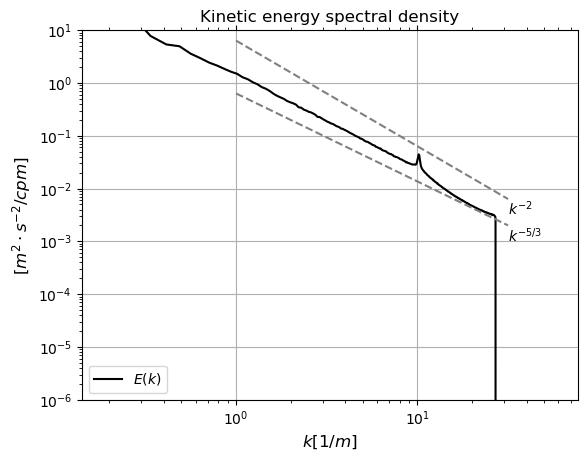

In [7]:
ks = np.array([1e0,10**1.5])
Es1 = .2e-2*(ks**(-5/3))/10**-2.5
Es2 = .2e-2*(ks**(-2))/10**-3.5
# Es3 = .2e-4*(ks**(-3))/10**-2.5

# fug = plt.figure(figsize=(8, 4))
# plt.subplot(1, 2, 1)
plt.loglog(Kiso, EKEisow, '-k',  label='$E(k)$')
plt.ylim([1e-6,1e1])



plt.plot(ks, Es1, '--', color='gray')
plt.text(10**1.5,10**-3,'$k^{-5/3}$')

plt.plot(ks, Es2, '--', color='gray')
plt.text(10**1.5,10**-2.5,'$k^{-2}$')

# plt.plot(ks, Es3, '--', color='gray')
# plt.text(10**1.5,10**-7,'$k^{-3}$')
plt.grid(True)

ax = plt.gca() 
ax.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True)  
# ax.set_xticks([1e-3,1e-4,1e-5,1e-6])
# ax.set_xticklabels(['1', '10', '100','1000'], fontsize=12)
plt.xlabel('$k[1/m]$',fontsize=12,fontweight='bold')
plt.ylabel('$[m^{2} \cdot s^{-2} /cpm ]$',fontsize=12,fontweight='bold')

plt.title('Kinetic energy spectral density')

# plt.ylabel('PSD $[m^{2}/s^{2}/{m^{-2}}]$',fontsize=12,fontweight='bold')
# plt.title('Kinetic spectrum',fontsize=12,fontweight='bold')
plt.legend(loc=3)
# plt.savefig('/meddy/simingzhang/Data/HIT2D/2dturbulence/fig1_KEspec_HIT2D.png', bbox_inches = 'tight', format='png', dpi=500)
plt.show()

## 1.3. Calc 2-order structure function use fft

In [8]:
N=512
dx=2*np.pi/512
rbin,_,_,_=test4_calc_SF2(u[0,:,:], v[0,:,:], N,dx)


/tmp/ipykernel_1684065/19765526.py:640: ComplexWarning: Casting complex values to real discards the imaginary part
  Sl_azimuth[idx] += S_longitudinal[i,j]
/tmp/ipykernel_1684065/19765526.py:641: ComplexWarning: Casting complex values to real discards the imaginary part
  St_azimuth[idx] += S_transverse[i,j]


In [9]:

SF2tw = np.zeros((rbin.shape[0],utime))
SF2lw = np.zeros_like(SF2tw)
SF2w = np.zeros_like(SF2tw)



SF3tw = np.zeros((rbin.shape[0],utime))

SF3lw = np.zeros_like(SF3tw)



import ray
from tqdm import tqdm
ray.init(
    num_cpus=8,
    runtime_env={
        "working_dir": ".",
        "excludes": ["*.nc", "*.hdf5"]  # 排除数据文件
    },
    ignore_reinit_error=True
)
@ray.remote
def process_single_timestep(ii, uw_slice, vw_slice, N):
    """处理单个时间步的全部四组数据"""
    # 强制模块重新加载（解决Ray环境隔离问题）
    rbin,SF2tw,SF2lw,SF2w=test2_calc_SF2(uw_slice,vw_slice,N)
    # rbin3,SF3tw,SF3lw=test4_calc_SF3(uw_slice,vw_slice,N,2*np.pi/512)
    # rbin3,SF3lw,SF3tw=calc_SF3_iso2(uw_slice,vw_slice,N)

    return ii, rbin, SF2tw, SF2lw, SF2w, SF3tw, SF3lw,rbin3


# uw_ref = ray.put(u)  # 将整个3D数组存入共享内存
# vw_ref = ray.put(v)


# 提交所有任务
futures = []
for ii in range(utime):
    # 获取当前时间步数据（提前转换为numpy数组）
    uw_slice = np.asarray(u[ii,:,:])
    vw_slice = np.asarray(v[ii,:,:])
    # print(uw_slice.shape)

    
    # 提交任务到集群
    future = process_single_timestep.remote(
        ii, uw_slice, vw_slice,  N
    )
    futures.append(future)
result=[]
# 动态获取结果（保持时间顺序）
with tqdm(total=utime, desc="Processing timesteps") as pbar:
    for _ in range(utime):
        # 获取最早完成的任务
        ready, _ = ray.wait(futures, num_returns=1)
        result = ray.get(ready[0])
        
        # 更新结果数组
        ii, rbin, SF2tw_t, SF2lw_t, SF2w_t, SF3tw_t, SF3lw_t,rbin3 = result
        SF2tw[:, ii] = SF2tw_t
        SF2lw[:, ii] = SF2lw_t
        SF2w[:, ii] = SF2w_t

        SF3lw[:, ii] = SF3lw_t
        SF3tw[:, ii] = SF3tw_t

        
        # 更新进度条
        pbar.update(1)
        futures.remove(ready[0])
        
ray.shutdown()


2025-07-16 08:51:08,224	INFO worker.py:1841 -- Started a local Ray instance.
2025-07-16 08:51:09,102	INFO packaging.py:575 -- Creating a file package for local module '.'.
2025-07-16 08:51:09,142	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_62cafc7645347e7d.zip' (13.19MiB) to Ray cluster...
2025-07-16 08:51:09,164	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_62cafc7645347e7d.zip'.
Processing timesteps:   0%|                                                          | 0/199 [00:00<?, ?it/s](process_single_timestep pid=1688706) /tmp/ipykernel_1684065/19765526.py:640: ComplexWarning: Casting complex values to real discards the imaginary part
(process_single_timestep pid=1688706) /tmp/ipykernel_1684065/19765526.py:641: ComplexWarning: Casting complex values to real discards the imaginary part
Processing timesteps: 100%|████████████████████████████████████████████████| 199/199 [00:45<00:00,  4.35it/s]
(process_single_timestep pid=1688687) /tmp/ip

## 1.4. transfer KE spec to SF2

In [10]:
#choose segment to transfer KE PSD to SF2
rbin=rbin*2*np.pi/512
sf2_EKEisow = E2SF2(EKEisow, Kiso*2*np.pi, 
                   np.mean(abs(Kiso[1:]-Kiso[:-1]))*2*np.pi, rbin)

In [11]:
sf2_EKEisow.shape,rbin.shape


((363,), (363,))

<>:4: SyntaxWarning: invalid escape sequence '\ '
<>:4: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_1684065/1349597636.py:4: SyntaxWarning: invalid escape sequence '\ '
  label='$SF2-from \ KE \ spec$')


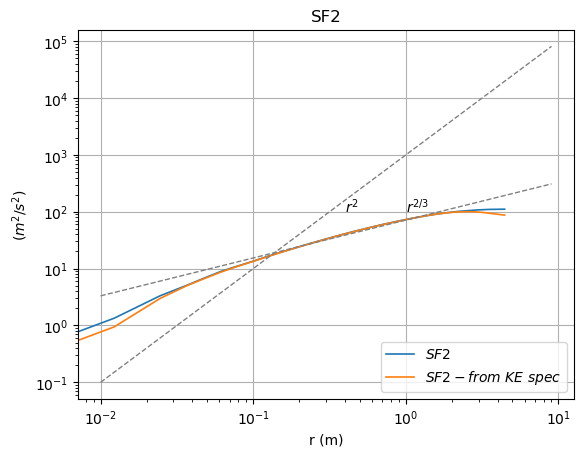

In [12]:
plt.loglog(rbin, np.nanmean(SF2w,1), linewidth=1.2,
           label='$SF2$')
plt.loglog(rbin, sf2_EKEisow, linewidth=1.2,
           label='$SF2-from \ KE \ spec$')
plt.loglog(np.arange(1e-2, 10, 1), np.arange(1e-2, 10, 1)**(2)/(1e-3), '--', linewidth=1, color='gray')
plt.text(10**-0.4, 1e2, r'$r^{2}$')

plt.loglog(np.arange(1e-2, 10, 1), np.arange(1e-2, 10, 1)**(2/3)/1.4e-2, '--', linewidth=1, color='gray')
plt.text(1e0, 1e2, r'$r^{2/3}$')

plt.grid(True)
# plt.xlim([1e-2,1e1])
# plt.ylim([1e0,1e3])
plt.xlabel('r (m)')
plt.ylabel(r'$(m^{2}/s^{2})$')
plt.title('SF2')
plt.legend(loc=4)
# plt.savefig('/meddy/simingzhang/Data/HIT2D/2dt2/SF2.png', bbox_inches = 'tight', format='png', dpi=500)
plt.show()

# 2. Iceland data
## 2.1. Import data

In [13]:

outpur_dir='/meddy/simingzhang/Data/RB_iceland_data/iceland_wave'


grid_dir='/meddy/simingzhang/Data/RB_iceland_data/'

os.chdir(grid_dir)
grid=xr.open_dataset('niskin2km_500m_grd.nc')

os.chdir(outpur_dir)
dataw=xr.open_dataset('z_niskin2km_his_hf_depth_500m_grd.0002.nc')

dsw = xr.merge([dataw,grid])
print(dsw)
print('\n data size: %.1f GB' %(dsw.nbytes / 1e9))

# nowave
outpur_dir='/meddy/simingzhang/Data/RB_iceland_data/iceland_no_wave'

grid_dir='/meddy/simingzhang/Data/RB_iceland_data/'

os.chdir(grid_dir)
grid=xr.open_dataset('niskin2km_500m_grd.nc')

os.chdir(outpur_dir)
datanw=xr.open_dataset('z_niskin2km_his_smooth_depth_500m_grd.0002.nc')
dsnw = xr.merge([datanw,grid])
print(dsnw)
print('\n data size: %.1f GB' %(dsnw.nbytes / 1e9))


os.chdir('/meddy/simingzhang/Data/RB_iceland_data/')


<xarray.Dataset> Size: 2GB
Dimensions:     (depth: 1, time: 2148, eta_rho: 287, xi_u: 286, eta_v: 286,
                 xi_rho: 287, one: 1, bath: 1, eta_u: 287, xi_v: 287,
                 eta_psi: 286, xi_psi: 286)
Coordinates:
  * depth       (depth) float32 4B -2.0
Dimensions without coordinates: time, eta_rho, xi_u, eta_v, xi_rho, one, bath,
                                eta_u, xi_v, eta_psi, xi_psi
Data variables: (12/38)
    ocean_time  (time) float32 9kB ...
    u           (time, depth, eta_rho, xi_u) float32 705MB ...
    v           (time, depth, eta_v, xi_rho) float32 705MB ...
    w           (time, depth, eta_rho, xi_rho) float32 708MB ...
    xl          (one) float64 8B ...
    el          (one) float64 8B ...
    ...          ...
    lat_v       (eta_v, xi_v) float64 657kB ...
    lat_psi     (eta_psi, xi_psi) float64 654kB ...
    mask_rho    (eta_rho, xi_rho) float64 659kB ...
    mask_u      (eta_u, xi_u) float64 657kB ...
    mask_v      (eta_v, xi_v) float64 657

In [14]:
uw=u2rho_3d(np.squeeze(dsw['u']).values)
vw=v2rho_3d(np.squeeze(dsw['v']).values)

unw=u2rho_3d(np.squeeze(dsnw['u']).values)
vnw=v2rho_3d(np.squeeze(dsnw['v']).values)

## 2.2. Calc spec

In [15]:
os.chdir('/meddy/simingzhang/Analysis/python/python3/SF3_RLS')
dx=2e3
dy=dx
utime,ix,jx=uw.shape

win1 =  np.hanning(ix)
win1 =  np.sqrt(ix/(win1**2).sum())*win1
win2 =  np.hanning(ix)
win2 =  np.sqrt(ix/(win2**2).sum())*win2
win = win1[np.newaxis,...]*win2[...,np.newaxis]


dx = 2e3
dy = dx
# Calculates expected wavenumber to allocate memory
l1,l2 = ix,jx
df1 = 1./(l1*dy)
df2 = 1./(l2*dx)
f1Ny = 1./(2*dy)
f2Ny = 1./(2*dx)

f1 = np.arange(-f1Ny,f1Ny,df1)
f2 = np.arange(-f2Ny,f2Ny,df2)

import ray
import numpy as np
from tqdm import tqdm

# 初始化Ray（关键配置）
ray.init(
    num_cpus=8, 
    runtime_env={"working_dir": "."},  # 确保模块可见
    ignore_reinit_error=True
)

# 预分配结果数组
Euw = np.zeros((len(f1), len(f2), utime))
Evw = np.zeros_like(Euw)
Eunw = np.zeros_like(Euw)
Evnw = np.zeros_like(Euw)

# 定义原子化任务（每个时间步完全独立）
@ray.remote
def process_single_timestep(ii, uw_slice, vw_slice, unw_slice, vnw_slice, win, dy, dx):
    """处理单个时间步的全部四组数据"""
    # 强制模块重新加载（解决Ray环境隔离问题）
    # from strucFunct import detrend_demean
    from spectralanalysis import spec_est2
    
    # 处理uw/vw
    uw_p, vw_p = detrend_demean(uw_slice, vw_slice)
    Euw,l,k,dl,dk,flNy,fkNy = spec_est2(uw_p * win, dy, dx, win=False)
    Evw,l,k,dl,dk,flNy,fkNy = spec_est2(vw_p * win, dy, dx, win=False)
    
    # 处理unw/vnw
    unw_p, vnw_p = detrend_demean(unw_slice, vnw_slice)
    Eunw,l,k,dl,dk,flNy,fkNy = spec_est2(unw_p * win, dy, dx, win=False)
    Evnw,l,k,dl,dk,flNy,fkNy = spec_est2(vnw_p * win, dy, dx, win=False)
    
    return ii,l,k,dl,dk,flNy,fkNy,Euw, Evw, Eunw, Evnw


uw_ref = ray.put(uw)  # 将整个3D数组存入共享内存
vw_ref = ray.put(vw)
unw_ref = ray.put(unw)
vnw_ref = ray.put(vnw)

# 提交所有任务
futures = []
for ii in range(utime):
    # 获取当前时间步数据（提前转换为numpy数组）
    uw_slice = np.asarray(uw[ii])
    vw_slice = np.asarray(vw[ii])
    unw_slice = np.asarray(unw[ii])
    vnw_slice = np.asarray(vnw[ii])
    
    # 提交任务到集群
    future = process_single_timestep.remote(
        ii, uw_slice, vw_slice, unw_slice, vnw_slice, win, dy, dx
    )
    futures.append(future)

# 动态获取结果（保持时间顺序）
with tqdm(total=utime, desc="Processing timesteps") as pbar:
    for _ in range(utime):
        # 获取最早完成的任务
        ready, _ = ray.wait(futures, num_returns=1)
        result = ray.get(ready[0])
        
        # 更新结果数组
        ii,l,k,dl,dk,flNy,fkNy,Euw_t, Evw_t, Eunw_t, Evnw_t = result
        Euw[:, :, ii] = Euw_t
        Evw[:, :, ii] = Evw_t
        Eunw[:, :, ii] = Eunw_t
        Evnw[:, :, ii] = Evnw_t
        
        # 更新进度条
        pbar.update(1)
        futures.remove(ready[0])

ray.shutdown()

2025-07-16 08:53:12,981	INFO worker.py:1841 -- Started a local Ray instance.
2025-07-16 08:53:13,002	INFO packaging.py:575 -- Creating a file package for local module '.'.
2025-07-16 08:53:13,042	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_62cafc7645347e7d.zip' (13.19MiB) to Ray cluster...
2025-07-16 08:53:13,079	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_62cafc7645347e7d.zip'.
Processing timesteps: 100%|█████████████████████████████████████████████| 2148/2148 [00:19<00:00, 110.36it/s]


In [16]:
EKEspcw = 0.5*(Euw + Evw) # KE 2D spectrum
EKEspcnw = 0.5*(Eunw + Evnw) # KE 2D spectrum
# np.asarray(uw[ii]).shape
# E222,l,k,dl,dk,flNy,fkNy = spec_est2( np.asarray(uw[ii])* win, dy, dx, win=False)
# EKEiso = np.zeros(())

EKEisow, Kiso = Ek2DEkiso(EKEspcw, k, l, dk, dl)
EKEisonw, Kiso = Ek2DEkiso(EKEspcnw, k, l, dk, dl)

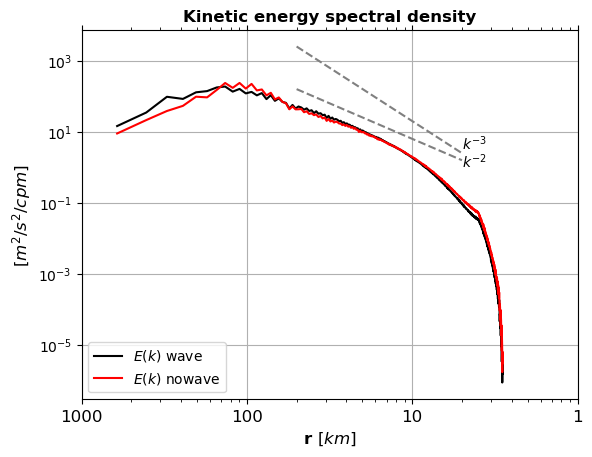

In [17]:
ks = np.array([2e-5,2e-4])
Es2 = .2e-2*(ks**(-2))/10**4.5
Es3 = .2e-4*(ks**(-3))/10**6

# fug = plt.figure(figsize=(8, 4))
# plt.subplot(1, 2, 1)
plt.loglog(Kiso, EKEisow, '-k',  label='$E(k)$ wave')
plt.loglog(Kiso, EKEisonw, '-r',  label='$E(k)$ nowave')

plt.plot(ks, Es2, '--', color='gray')
plt.text(2e-4,10**0,'$k^{-2}$')
plt.plot(ks, Es3, '--', color='gray')
plt.text(2e-4,10**0.5,'$k^{-3}$')
plt.grid(True)

ax = plt.gca() 
ax.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True)  
ax.set_xticks([1e-3,1e-4,1e-5,1e-6])
ax.set_xticklabels(['1', '10', '100','1000'], fontsize=12)
plt.xlabel('r $[km]$',fontsize=12,fontweight='bold')
plt.ylabel('$[m^{2}/s^{2}/cpm]$',fontsize=12,fontweight='bold')
plt.title('Kinetic energy spectral density',fontsize=12,fontweight='bold')
plt.legend(loc=3)
# plt.savefig('D:/LIN2023/model/RoyBarkan/SF3_RLS-main/fig1_KEspec_RB.png', bbox_inches = 'tight', format='png', dpi=500)
plt.show()

## 2.3. Calc 2-order structure function use fft

In [50]:
N=287
dx=2e3
# del rbin
# rbin,_,_,_=test4_calc_SF2(uw[0,:,:], vw[0,:,:], N, dx)
rbin,_,_,_=test2_calc_SF2(uw[0,:,:], vw[0,:,:], N)

/tmp/ipykernel_1684065/19765526.py:329: ComplexWarning: Casting complex values to real discards the imaginary part
  St_azimuth[ii] = np.mean(S_transverse[pos])
/tmp/ipykernel_1684065/19765526.py:330: ComplexWarning: Casting complex values to real discards the imaginary part
  Sl_azimuth[ii] = np.mean(S_longitudinal[pos])


In [51]:
SF2tw = np.zeros((rbin.shape[0],utime))
SF2lw = np.zeros_like(SF2tw)
SF2w = np.zeros_like(SF2tw)

SF2tnw = np.zeros((rbin.shape[0],utime))
SF2lnw = np.zeros_like(SF2tw)
SF2nw = np.zeros_like(SF2tw)


# SF3tw = np.zeros((rbin.shape[0],utime))
# SF3lw = np.zeros_like(SF3tw)



import ray
from tqdm import tqdm
ray.init(
    num_cpus=8,
    runtime_env={
        "working_dir": ".",
        "excludes": ["*.nc", "*.hdf5"]  # 排除数据文件
    },
    ignore_reinit_error=True
)
@ray.remote
def process_single_timestep(ii, uw_slice, vw_slice,unw_slice, vnw_slice, N):
    """处理单个时间步的全部四组数据"""
    # 强制模块重新加载（解决Ray环境隔离问题）
    # rbin,SF2tw,SF2lw,SF2w=test4_calc_SF2(uw_slice,vw_slice,N,dx)
    # rbin,SF2tnw,SF2lnw,SF2nw=test4_calc_SF2(unw_slice,vnw_slice,N,dx)
    rbin,SF2tw,SF2lw,SF2w=test2_calc_SF2(uw_slice,vw_slice,N)
    rbin,SF2tnw,SF2lnw,SF2nw=test2_calc_SF2(unw_slice,vnw_slice,N)
    # rbin3,SF3tw,SF3lw=test4_calc_SF3(uw_slice,vw_slice,N,dx)
    # rbin3,SF3lw,SF3tw=calc_SF3_iso2(uw_slice,vw_slice,N)

    return ii, rbin, SF2tw, SF2lw, SF2w ,SF2tnw, SF2lnw, SF2nw


# uw_ref = ray.put(u)  # 将整个3D数组存入共享内存
# vw_ref = ray.put(v)


# 提交所有任务
futures = []
for ii in range(utime):
    # 获取当前时间步数据（提前转换为numpy数组）
    uw_slice = np.asarray(uw[ii,:,:])
    vw_slice = np.asarray(vw[ii,:,:])
    unw_slice = np.asarray(unw[ii,:,:])
    vnw_slice = np.asarray(vnw[ii,:,:])
    # print(uw_slice.shape)

    
    # 提交任务到集群
    future = process_single_timestep.remote(
        ii, uw_slice, vw_slice, unw_slice, vnw_slice, N
    )
    futures.append(future)
result=[]
# 动态获取结果（保持时间顺序）
with tqdm(total=utime, desc="Processing timesteps") as pbar:
    for _ in range(utime):
        # 获取最早完成的任务
        ready, _ = ray.wait(futures, num_returns=1)
        result = ray.get(ready[0])
        
        # 更新结果数组
        ii, rbin, SF2tw_t, SF2lw_t, SF2w_t ,SF2tnw_t, SF2lnw_t, SF2nw_t = result
        SF2tw[:, ii] = SF2tw_t
        SF2lw[:, ii] = SF2lw_t
        SF2w[:, ii] = SF2w_t

        SF2tnw[:, ii] = SF2tnw_t
        SF2lnw[:, ii] = SF2lnw_t
        SF2nw[:, ii] = SF2nw_t

        # SF3lw[:, ii] = SF3lw_t
        # SF3tw[:, ii] = SF3tw_t

        
        # 更新进度条
        pbar.update(1)
        futures.remove(ready[0])
        
ray.shutdown()


2025-07-16 09:50:23,996	INFO worker.py:1841 -- Started a local Ray instance.
2025-07-16 09:50:24,017	INFO packaging.py:575 -- Creating a file package for local module '.'.
2025-07-16 09:50:24,057	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_21ca43579cb5b0f5.zip' (13.18MiB) to Ray cluster...
2025-07-16 09:50:24,077	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_21ca43579cb5b0f5.zip'.
(process_single_timestep pid=1707051) /tmp/ipykernel_1684065/19765526.py:329: ComplexWarning: Casting complex values to real discards the imaginary part
(process_single_timestep pid=1707051) /tmp/ipykernel_1684065/19765526.py:330: ComplexWarning: Casting complex values to real discards the imaginary part
Processing timesteps: 100%|█████████████████████████████████████████████| 2148/2148 [00:11<00:00, 181.03it/s]
(process_single_timestep pid=1707057) /tmp/ipykernel_1684065/19765526.py:330: ComplexWarning: Casting complex values to real discards the imaginary part [

## 2.4. transfer KE PSD to SF2

In [52]:
rbin=rbin*2e3
sf2_EKEisow = E2SF2(EKEisow, Kiso*2*np.pi, 
                   np.mean(abs(Kiso[1:]-Kiso[:-1]))*2*np.pi, rbin)

sf2_EKEisonw = E2SF2(EKEisonw, Kiso*2*np.pi, 
                   np.mean(abs(Kiso[1:]-Kiso[:-1]))*2*np.pi, rbin)

## 2.5. Local Ro, Transverse/Longidinal, degree of freedom
### $T_{scale}=r/\sqrt{SF2}$, $N^{DOF}=T_{total}/T_{scale}$, from Balwada et al. 2022 Sci adv
### local Ro $Ro_{local}=\sqrt{SF2}/f/r$, from Balwada et al. 2016 GRL
### $\frac{S_{\perp}}{S_{\parallel}}\approx\frac{\zeta^{2}+\alpha^{2}/2}{\delta^{2}+\alpha^{2}/2}$, from Hypolite et al. 2025 JPO

In [53]:
Tscalew=rbin/(np.nanmean(SF2w,1)**(1/2))
Tscalenw=rbin/(np.nanmean(SF2nw,1)**(1/2))
Tmax=SF2w.shape[1]*3600


f=np.nanmean(grid['f'].values)
local_Ro_w=np.sqrt(np.nanmean(SF2w,1))/f/rbin
local_Ro_nw=np.sqrt(np.nanmean(SF2nw,1))/f/rbin

In [73]:
# rbin

array([  1414.21356237,   4242.64068712,   7071.06781187,   9899.49493661,
        12727.92206136,  15556.3491861 ,  18384.77631085,  21213.2034356 ,
        24041.63056034,  26870.05768509,  29698.48480983,  32526.91193458,
        35355.33905933,  38183.76618407,  41012.19330882,  43840.62043357,
        46669.04755831,  49497.47468306,  52325.9018078 ,  55154.32893255,
        57982.7560573 ,  60811.18318204,  63639.61030679,  66468.03743154,
        69296.46455628,  72124.89168103,  74953.31880577,  77781.74593052,
        80610.17305527,  83438.60018001,  86267.02730476,  89095.4544295 ,
        91923.88155425,  94752.308679  ,  97580.73580374, 100409.16292849,
       103237.59005324, 106066.01717798, 108894.44430273, 111722.87142747,
       114551.29855222, 117379.72567697, 120208.15280171, 123036.57992646,
       125865.00705121, 128693.43417595, 131521.8613007 , 134350.28842544,
       137178.71555019, 140007.14267494, 142835.56979968, 145663.99692443,
       148492.42404917, 1

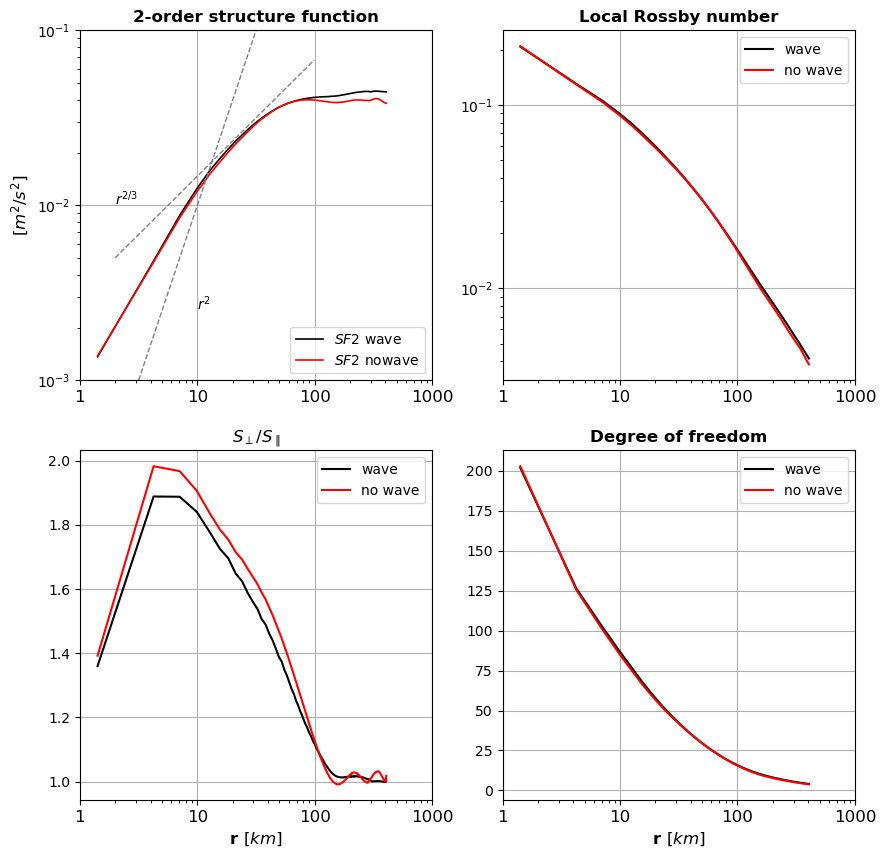

In [75]:
fig3,ax3=plt.subplots(2,2,figsize=(10,10))

ax3[0][0].loglog(rbin*1e-3, np.nanmean(SF2w,1), linewidth=1.2,
           label='$SF2$ wave',color='k')
# ax3[0][0].loglog(rbin*1e-3, sf2_EKEisow, linewidth=1.2,
#            label='$SF2$ wave -from  KE  spec',color='k',linestyle='--')

ax3[0][0].loglog(rbin*1e-3, np.nanmean(SF2nw,1), linewidth=1.2,
           label='$SF2$ nowave',color='r')
# plt.loglog(rbin*1e-3, sf2_EKEisonw, linewidth=1.2,
#            label='$SF2$ nowave -from  KE  spec',color='r',linestyle='--')

ax3[0][0].loglog(np.arange(2, 100, 1), np.arange(2, 100, 1)**(2)/(1e4), '--', linewidth=1, color='gray')
ax3[0][0].text(10, 10**-2.6, r'$r^{2}$')

ax3[0][0].loglog(np.arange(2, 100, 1), np.arange(2, 100, 1)**(2/3)/(10**2.5), '--', linewidth=1, color='gray')
ax3[0][0].text(2, 10**-2, r'$r^{2/3}$')

ax3[0][0].grid(True)

ax3[0][0].set_xticks([1,10,100,1000])
ax3[0][0].set_xticklabels(['1', '10', '100','1000'], fontsize=12)
ax3[0][0].set_ylim([1e-3,1e-1])
# ax3[0][0].set_xlabel('r $[km]$',fontsize=12,fontweight='bold')
ax3[0][0].set_ylabel('$[m^{2}/s^{2} ]$',fontsize=12,fontweight='bold')
ax3[0][0].set_title('2-order structure function',fontsize=12,fontweight='bold')
ax3[0][0].legend(loc=4)
# plt.savefig('D:/LIN2023/model/RoyBarkan/SF3_RLS-main/fig1_KEspec_RB.png', bbox_inches = 'tight', format='png', dpi=500)


# ax3[0][1].semilogx(rbin*1e-3,np.nanmean(SF2tw,1)/np.nanmean(SF2lw,1))

ax3[1][0].semilogx(rbin*1e-3,np.nanmean(SF2tw,1)/np.nanmean(SF2lw,1),color='k', label='wave')
ax3[1][0].semilogx(rbin*1e-3,np.nanmean(SF2tnw,1)/np.nanmean(SF2lnw,1),color='r', label='no wave')
ax3[1][0].grid(True)

ax3[1][0].set_xticks([1,10,100,1000])
ax3[1][0].set_xticklabels(['1', '10', '100','1000'], fontsize=12)
ax3[1][0].set_xlabel('r $[km]$',fontsize=12,fontweight='bold')
# ax3[1][0].set_ylabel('$[m^{2}/s^{2} ]$',fontsize=12,fontweight='bold')
ax3[1][0].set_title(r'$S_{\perp}/S_{\parallel}$',fontsize=12,fontweight='bold')
ax3[1][0].legend(loc=1)




ax3[0][1].loglog(rbin*1e-3,local_Ro_w,color='k', label='wave')
ax3[0][1].loglog(rbin*1e-3,local_Ro_nw,color='r', label='no wave')
ax3[0][1].grid(True)

ax3[0][1].set_xticks([1,10,100,1000])
ax3[0][1].set_xticklabels(['1', '10', '100','1000'], fontsize=12)
# ax3[0][1].set_xlabel('r $[km]$',fontsize=12,fontweight='bold')
# ax3[0][1].set_ylabel('$[m^{2}/s^{2} ]$',fontsize=12,fontweight='bold')
ax3[0][1].set_title(r'Local Rossby number',fontsize=12,fontweight='bold')
ax3[0][1].legend(loc=1)


ax3[1][1].semilogx(rbin*1e-3,Tmax/Tscalew,color='k', label='wave')
ax3[1][1].semilogx(rbin*1e-3,Tmax/Tscalenw,color='r', label='no wave')
ax3[1][1].grid(True)
ax3[1][1].set_xticks([1,10,100,1000])
ax3[1][1].set_xticklabels(['1', '10', '100','1000'], fontsize=12)
ax3[1][1].set_xlabel('r $[km]$',fontsize=12,fontweight='bold')
# ax3[1][1].set_ylabel('$[m^{2}/s^{2} ]$',fontsize=12,fontweight='bold')
ax3[1][1].set_title(r'Degree of freedom',fontsize=12,fontweight='bold')
ax3[1][1].legend(loc=1)




plt.show()
